In [1]:
import numpy as np
import cv2

In [2]:
PATH = r'C:\\Users\\rjgle\\Documents\\Python Things\\ATRA differentiation\\2022.03.03 C2C12 ATRA differentiation\\ATRA 1 nM\\2022.03.03 A1 1-D.tif'

In [3]:
image = cv2.imread(PATH)

(960, 1280, 3)


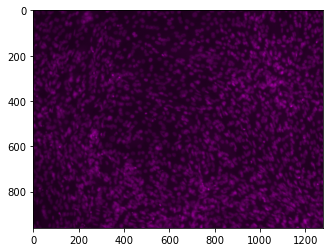

In [4]:
import matplotlib.pyplot as plt

print(image.shape)
plt.imshow(image)

In [5]:
#The images are 960x1280
#We want to break them up in 64x64 sub-images
M = 64
N = 64
tiles = [image[x:x+M,y:y+N] for x in range(0,image.shape[0],M) for y in range(0,image.shape[1],N)]

In [6]:
len(tiles)

300

In [7]:
#PATH TO EXPERIEMENT ONE
PATH_1 = 'C:\\Users\\rjgle\\Documents\\Python Things\\ATRA differentiation\\2022.03.03 C2C12 ATRA differentiation'
#PATH TO EXPERIMENT TWO
PATH_2 = 'C:\\Users\\rjgle\\Documents\\Python Things\\ATRA differentiation\\2022.03.21 C2C12 ATRA IGF1 Differentiation'

In [8]:
import os
from PIL import Image

#Break images up into 64x64 tiles
M = 64
N = 64

data = []

#Images in path 1
for file in os.listdir(PATH_1):
    f = os.path.join(PATH_1, file)
    if not f.endswith(".txt"):
        for filename in os.listdir(f):
                image_path = os.path.join(f, filename)
                if image_path.endswith(".tif") and "1-D" in image_path:
                    image = Image.open(image_path)
                    image = np.asarray(image)
                    tiles = [image[x:x+M,y:y+N] for x in range(0,image.shape[0],M) for y in range(0,image.shape[1],N)]
                    data.append(tiles)
#Images in path 2
for file in os.listdir(PATH_2):
    f = os.path.join(PATH_2, file)
    if not f.endswith(".txt"):
        for filename in os.listdir(f):
                image_path = os.path.join(f, filename)
                if image_path.endswith(".tif") and "1-D" in image_path:
                    image = Image.open(image_path)
                    image = np.asarray(image)
                    tiles = [image[x:x+M,y:y+N] for x in range(0,image.shape[0],M) for y in range(0,image.shape[1],N)]
                    data.append(tiles)
                    
new_data = np.asarray(data)
new_data = np.reshape(new_data, (10800, 64, 64, 3))
new_data = np.transpose(new_data, (0,3,1,2))
new_data.shape

(10800, 3, 64, 64)

In [9]:
#Utility functions to un-normalize and display an image
def imshow(img):
    plt.imshow(img) 

In [10]:
#Attempt to normalize image data
arrs = [np.array(image).transpose(2, 0, 1) for image in new_data]
arrs = [np.divide(arr, 255) for arr in arrs]
arrs = np.asarray(arrs)
arrs = np.transpose(arrs,(0,2,1,3))
arrs.shape

(10800, 3, 64, 64)

In [12]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

train_indices, test_indices = train_test_split(
    range(len(arrs)),
    test_size=0.10,
    random_state=14
)

# generate subset based on indices
train_split = Subset(arrs, train_indices)
test_split = Subset(arrs, test_indices)

In [13]:
train_dataloader = DataLoader(train_split, batch_size=32, num_workers=2, shuffle=True)
test_dataloader = DataLoader(test_split, batch_size=32, num_workers=2, shuffle=True)

[[[0.15686275 0.15686275 0.16470588 ... 0.27058824 0.27843137 0.29019608]
  [0.17254902 0.16078431 0.17254902 ... 0.29411765 0.29411765 0.30980392]
  [0.17254902 0.16862745 0.16078431 ... 0.30588235 0.30196078 0.30196078]
  ...
  [0.25882353 0.27058824 0.25490196 ... 0.26666667 0.24705882 0.24313725]
  [0.24705882 0.22745098 0.23529412 ... 0.29019608 0.27058824 0.25490196]
  [0.22352941 0.23137255 0.22352941 ... 0.30980392 0.30980392 0.29803922]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.15686275 0.15686275 0.16470588 ... 0.27058824 0.27843137 0.29019608]
  [0.17254902 0.160784

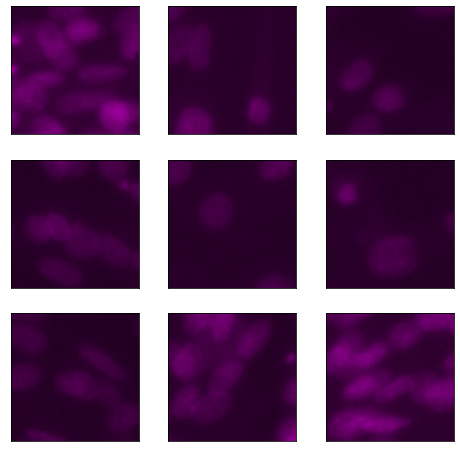

In [14]:
#Obtain one batch of training images
dataiter = iter(train_dataloader)
images = dataiter.next()
images = images.numpy() # convert images to numpy for display
print(images[0])

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 20 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx].transpose(1,2,0))

In [25]:
import torch.nn as nn
import torch.nn.functional as F

#Define the Convolutional Autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 2, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(2, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x.float()))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = F.sigmoid(self.t_conv2(x))
              
        return x
    
    def encode(self, x):
        x = F.relu(self.conv1(x.float()))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        
        return x

#Instantiate the model
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(2, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [26]:
import torch 

#Loss function
criterion = nn.BCELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)

cuda:0


ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(2, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)

In [28]:
#Epochs
n_epochs = 50

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    #Training
    for data in train_dataloader:
        images = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.float(), images.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_dataloader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 14.373815
Epoch: 2 	Training Loss: 11.471519
Epoch: 3 	Training Loss: 11.236690
Epoch: 4 	Training Loss: 11.190292
Epoch: 5 	Training Loss: 11.160046
Epoch: 6 	Training Loss: 11.143952
Epoch: 7 	Training Loss: 11.138735
Epoch: 8 	Training Loss: 11.136638
Epoch: 9 	Training Loss: 11.135204
Epoch: 10 	Training Loss: 11.134175
Epoch: 11 	Training Loss: 11.133257
Epoch: 12 	Training Loss: 11.132642
Epoch: 13 	Training Loss: 11.132095
Epoch: 14 	Training Loss: 11.131752
Epoch: 15 	Training Loss: 11.131450
Epoch: 16 	Training Loss: 11.131218
Epoch: 17 	Training Loss: 11.131042
Epoch: 18 	Training Loss: 11.130914
Epoch: 19 	Training Loss: 11.130767
Epoch: 20 	Training Loss: 11.130674
Epoch: 21 	Training Loss: 11.130527
Epoch: 22 	Training Loss: 11.130444
Epoch: 23 	Training Loss: 11.130317
Epoch: 24 	Training Loss: 11.130169
Epoch: 25 	Training Loss: 11.130030
Epoch: 26 	Training Loss: 11.129879
Epoch: 27 	Training Loss: 11.129842
Epoch: 28 	Training Loss: 11.129758
E

In [29]:
#Batch of test images
dataiter = iter(test_dataloader)
images = dataiter.next()
images = images.to(device)

In [30]:
#Sample outputs
output = model(images)
images = images.cpu().numpy()

In [31]:
batch_size = 32
output = output.view(batch_size, 3, 64, 64)
output = output.detach().cpu().numpy()

Original Images


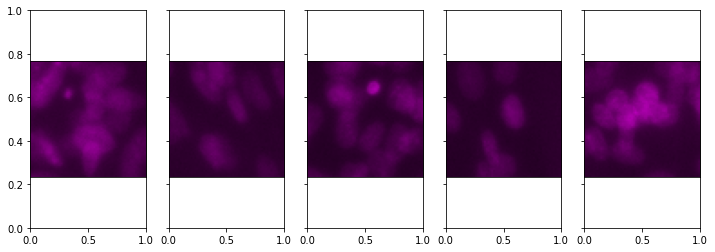

In [32]:
#Original Images
print("Original Images")
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    image_to_show = np.transpose(images[idx], (1,2,0))
    imshow(image_to_show)
plt.show()

Reconstructed Images


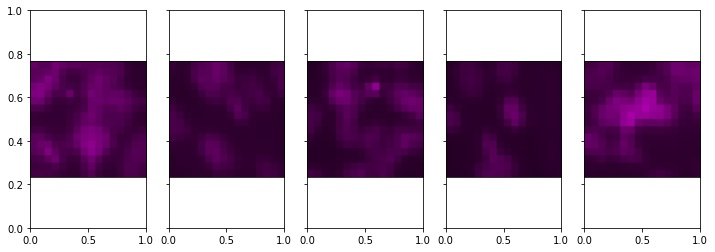

In [33]:
#Reconstructed Images
print('Reconstructed Images')
fig, axes = plt.subplots(nrows=1, ncols=5, sharex=True, sharey=True, figsize=(12,4))
for idx in np.arange(5):
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    outputs_to_show = np.transpose(output[idx], (1,2,0))
    imshow(outputs_to_show)
plt.show()

In [34]:
#Save model
torch.save(model.state_dict, "CAE_1_D.pth")

In [53]:
#Plot encoded images on scatter plot after training
model.eval()
print(device)
model.to(device)

encoded_images_arr = np.array([])
for image in arrs:
    image_tensor = torch.from_numpy(image)
    image_tensor = image_tensor.to(device)
    print(image_tensor.size())
    encoded_image = model.encode(image_tensor)
    print(encoded_image.size())
    encoded_images_arr = np.append([encoded_images_arr], [encoded_image.cpu().detach().numpy()], axis=0)
    
print(encoded_images_arr.shape)

cuda:0
torch.Size([3, 64, 64])
torch.Size([2, 16, 16])


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 4 dimension(s)

In [45]:
encoded_images_arr

array([19.64276314, 19.19759369, 17.85085487, ...,  0.        ,
        0.        ,  0.        ])